<a href="https://colab.research.google.com/github/sunRise9551/Building_Micrograd_from_Scratch/blob/main/Building_Micrograd_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Understand Concept of Derivative

Let's say we have a function f(x)

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

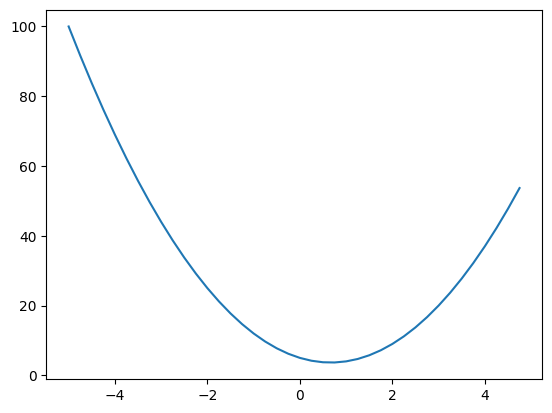

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Let's say we want to calculate the derivative of:
x with respect to f()

In [6]:
h = 0.000001 # represents a small increment for calculating the derivative
x = 2/3 # the point of the above graph when x=2/3
(f(x + h) - f(x)) / h # the slope of that point, which approximates the derivative

2.999378523327323e-06

More complex function

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


We now have a function f(a*b + c)

We want to calculate the derivative of:

'a' with respect to 'f'

'b' with respect to 'f'

'c' with respect to 'f'

So, We will bump tiny amount of h to 'a' 'b' 'c' each time and calculate their derivative

Derivative for 'a'

In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # computes the result before 'a' being increment
a += h # increment 'a' by h amount
d2 = a*b + c # computes the result after 'a' being increment

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # this is the derivative for 'a'

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


Derivative for 'b'

In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # computes the result before 'b' being increment
b += h # increment 'c' by h amount
d2 = a*b + c # computes the result after 'b' being increment

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # this is the derivative for 'b'

d1 4.0
d2 4.0002
slope 2.0000000000042206


Derivative for 'c'

In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # computes the result before 'c' being increment
c += h # increment 'c' by h amount
d2 = a*b + c # computes the result after 'c' being increment

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # this is the derivative for 'c'

d1 4.0
d2 4.0001
slope 0.9999999999976694


We have now understand how derivative works, we can then start working on creating Value object for micrograd

Create a Value Object that can perform + and * operation

In [16]:
class Value:

  def __init__(self, data):
    self.data = data # store data

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data) # Take in self.data + other.data
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data) # Take in self.data * other.data
    return out

In [20]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

print(a*b)
print(a.__mul__(b)) # equivalent to this

print(a*b + c)
print((a.__mul__(b)).__add__(c)) # equivalent to this


Value(data=-6.0)
Value(data=-6.0)
Value(data=4.0)
Value(data=4.0)


Create a variable to store its childs

This is the concept:
1. We will create a new variable 'a _children=()' tuple to store its parents
2. When we are creating a Value, it will not store anything to the tuple
3. When we are doing Addition or Multiplication, we will assign its parent to the tuple


In [21]:
class Value:

  def __init__(self, data, _children=()):
    self.data = data # store data
    self._prev = set(_children)

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,
                (self, other) # Pass itself and other to the tuple
                )
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,
                (self, other) # Pass itself and other to the tuple
                )
    return out

In [24]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c

print(d._prev)

# We can now see that the childrens for 'd' are (a*b) and (c)
# (a*b) and (c)
# (2.0*-3.0) and (10.0)
# (-6.0) and (10.0)

{Value(data=-6.0), Value(data=10.0)}


Create a variable _op=' ' to store its operations

In [32]:
class Value:

  def __init__(self, data, _children=(), _op=''):
    self.data = data # store data
    self._prev = set(_children)
    self._op = _op

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,
                (self, other),
                _op='+'
                )
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,
                (self, other),
                _op='*'
                )
    return out

In [34]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c

print(d._op)
# We can now know that the 'd' variable is compute by sum '+'

+


Visualize What we have done so far

In [41]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it

    # -------------------------- No Label and Grad for Now --------------------------------------
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ data %.4f }" % (n.data), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

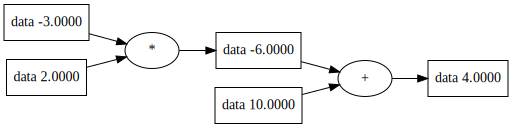

In [42]:
draw_dot(d)

Create Label for our Graph

In [43]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data # store data
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,
                (self, other),
                _op='+'
                )
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,
                (self, other),
                _op='*'
                )
    return out

In [44]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

Visualize Label

In [45]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it

    # -------------------------- No Grad for Now --------------------------------------
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

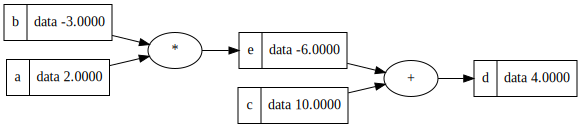

In [46]:
draw_dot(d)

Let's make another variable L to be the last output

In [47]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f
L

Value(data=-8.0)

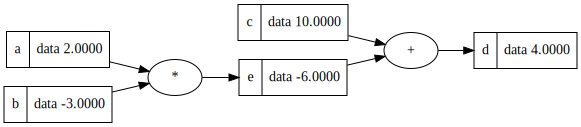

In [48]:
draw_dot(d)